In [1]:
import torch
TRAIN_IMG_SIZE = (480, 640, 3)
VAL_IMG_SIZE = TRAIN_IMG_SIZE
TEST_IMG_SIZE = TRAIN_IMG_SIZE
N_CLASSES = 12
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
NUM_EPOCHS = 35
TRAIN_NUM_WORKERS = 2
VAL_NUM_WORKERS = 2
TEST_NUM_WORKERS = 2
PIN_MEMORY = True
LEARNING_RATE = 0.001
TRAIN_NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LOAD_MODEL = False

START_EPOCH = 0
DATA_DIR ='../input/rescuenet/RescueNet'
print(DEVICE)

cuda


In [2]:
!pip install segmentation-models-pytorch
!pip install torchsummary
import segmentation_models_pytorch.utils


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.5 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9ec55b140f4f64c16de074ceb36c96a9c942b6eff7209b480f28ec7b3eda27ac
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e10ceac156ac7f42c3d4db9aa582699cd59bb6603c60d129e8457369e73f88bd
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import cv2
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm


from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import torchsummary as summary

torch.set_default_dtype(torch.float32)

torch.backends.cudnn.benchmark = True

In [4]:
def get_dir(subPath):  
    image_dir = os.path.join(DATA_DIR, subPath, subPath+"-org-img/" )
    label_dir = os.path.join(DATA_DIR, subPath, subPath+"-label-img/" )
    return [image_dir, label_dir]

In [5]:
x_train_dir, y_train_dir = get_dir('train')
x_val_dir, y_val_dir = get_dir('val')
x_test_dir, y_test_dir = get_dir('test')

In [6]:
def listFiles(subPath):
    org_dir, label_dir = get_dir(subPath)
    df = pd.DataFrame(columns=['folder_path','image_name', 'extension'])

    for img in os.listdir(org_dir):
        info = {
            'folder_path': [org_dir], 
            'image_name': [img[0:5]], 
            'extension': ['jpg']}
        info_ = pd.DataFrame(data=info)
        df = pd.concat((df, info_))

    df = df.drop_duplicates(subset=['image_name'])

    imgs = df.iloc[:,0] + df.iloc[:,1] + '.jpg'
    imgs = imgs.reset_index(drop=True)
    labels = label_dir + df.iloc[:,1] + '_lab.png'
    labels = labels.reset_index(drop=True)

    df = pd.concat((imgs,labels),axis=1)
    return df

In [7]:
train_df = listFiles('train')
val_df = listFiles('val')
test_df = listFiles('test')
train_df.iloc[:, 1].values

array(['../input/rescuenet/RescueNet/train/train-label-img/13288_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11925_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11378_lab.png',
       ...,
       '../input/rescuenet/RescueNet/train/train-label-img/13877_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11205_lab.png',
       '../input/rescuenet/RescueNet/train/train-label-img/11590_lab.png'],
      dtype=object)

In [8]:
print('train set size:',len(train_df))
print('val set size:',len(val_df))
print('test set size:',len(test_df))

train set size: 3595
val set size: 449
test set size: 450


In [9]:
len(train_df.iloc[:, 1]) == len(train_df.iloc[:,0])

True

In [10]:
class RescueNetDataset(Dataset):
    def __init__(self, df, transforms):
        super(RescueNetDataset, self).__init__()
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path, mask_path = self.df.loc[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        transformed = self.transforms(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        
        
        img = img/255
        img = img.astype('float32')

        img = np.transpose(img, (2,0,1))
        
        mask_stacked = np.array([mask==0])
        for i in range(1, 12):
            mask_stacked = np.concatenate([mask_stacked, np.array([mask==i])])
        mask = mask_stacked.astype(int)
        mask = mask.astype('int64')
        
        img = torch.from_numpy(img)
        mask = torch.from_numpy(mask)
        
        return img, mask


train_transforms = albu.Compose([
    albu.RandomScale(scale_limit=0.1),
    albu.Flip(),
    albu.Rotate(limit=30),
    albu.Resize(TRAIN_IMG_SIZE[0], TRAIN_IMG_SIZE[1]),
])

val_transforms = albu.Compose([
    albu.Resize(VAL_IMG_SIZE[0], VAL_IMG_SIZE[1]),
])

test_transforms = albu.Compose([
    albu.Resize(TEST_IMG_SIZE[0], TEST_IMG_SIZE[1]),
])

train_dataset = RescueNetDataset(df=train_df, transforms=train_transforms)
val_dataset = RescueNetDataset(df=val_df, transforms=val_transforms)
test_dataset = RescueNetDataset(df=test_df, transforms=test_transforms)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=TRAIN_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=TEST_NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)

torch.Size([8, 3, 480, 640]) torch.Size([8, 12, 480, 640])
torch.float32


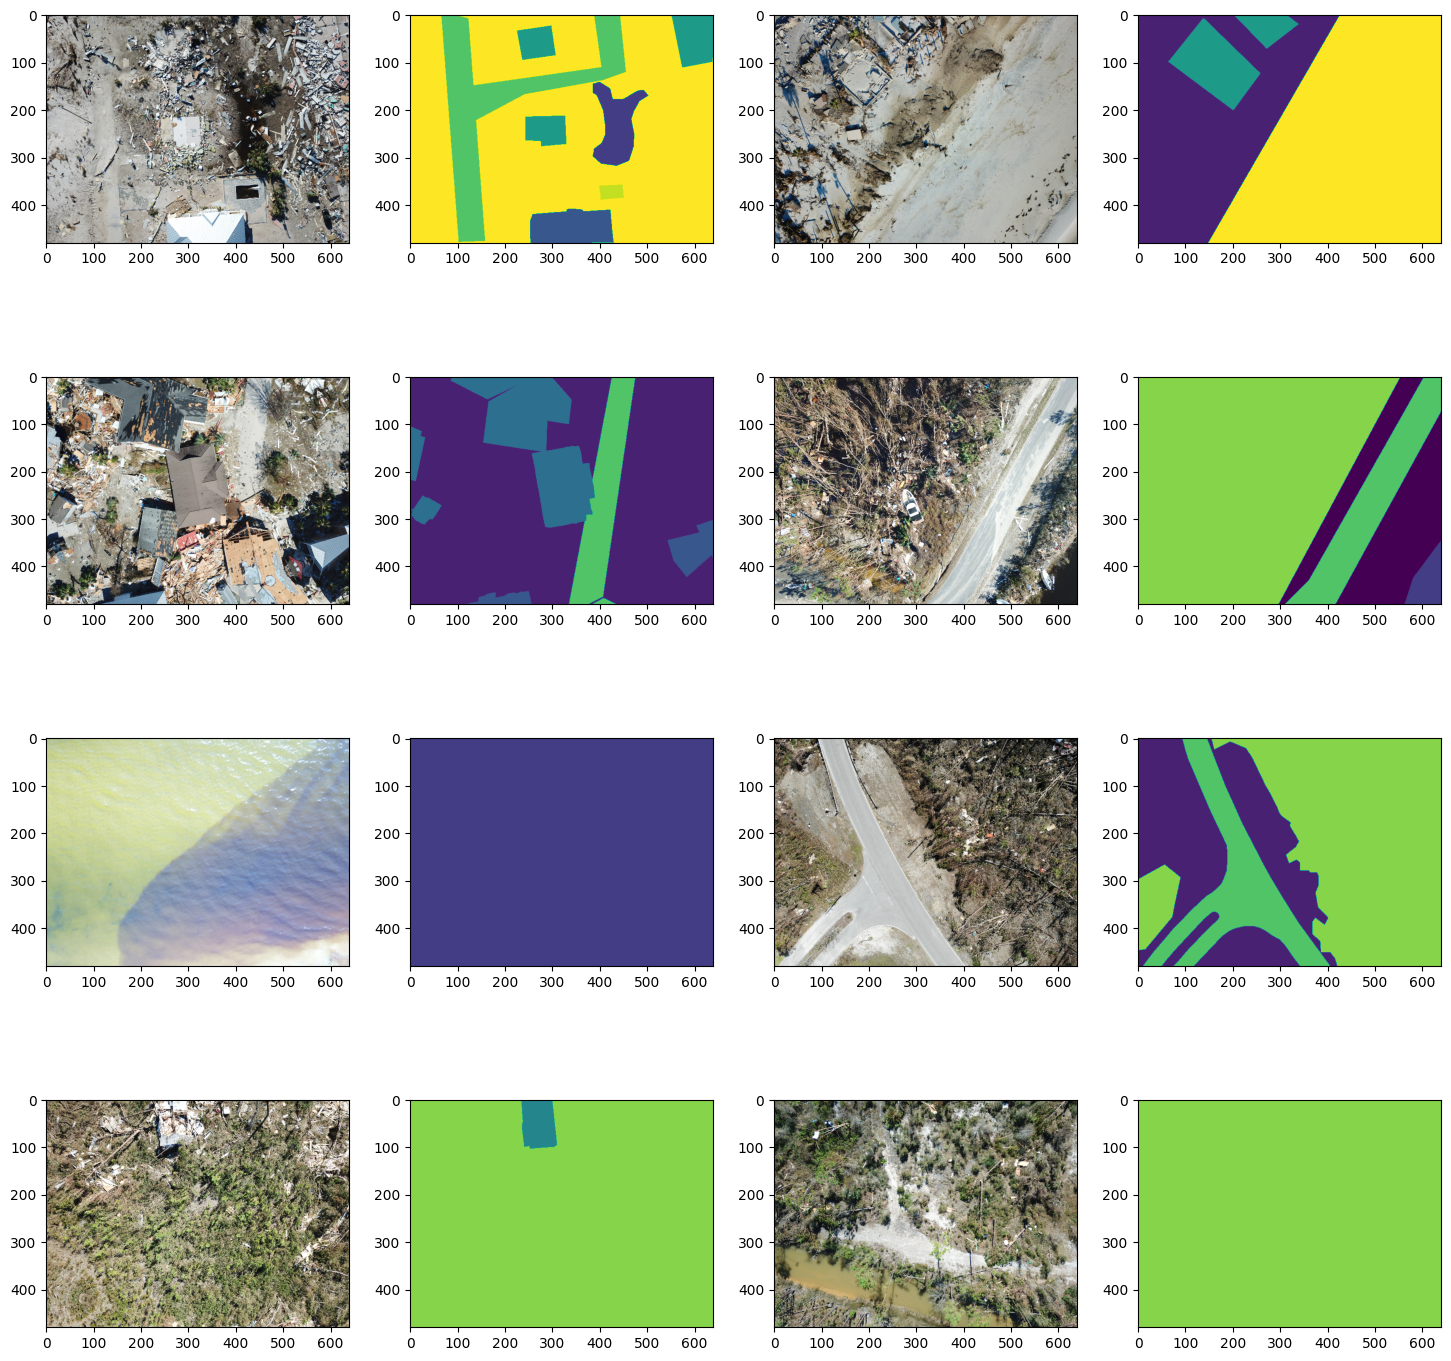

In [11]:
iterator = iter(train_loader)
imgs, masks = next(iterator)
print(imgs.shape, masks.shape)
print(imgs.dtype)

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(18,18))

count = 0
for r in range(4):
    axs[r,0].imshow(imgs[count].permute(1,2,0))
    axs[r,1].imshow(np.argmax(masks[count], axis=0), vmin=0, vmax=11)
    count += 1
    axs[r,2].imshow(imgs[count].permute(1,2,0))
    axs[r,3].imshow(np.argmax(masks[count], axis=0), vmin=0, vmax=11)
    count += 1

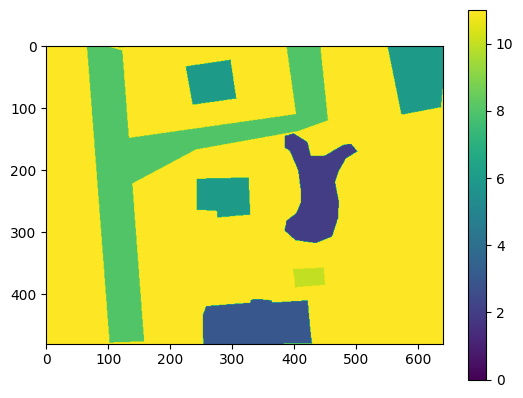

In [12]:
plt.imshow(np.argmax(masks[0], axis=0), vmin=0, vmax=11)
plt.colorbar()

In [13]:
import segmentation_models_pytorch as smp
from torchsummary import summary
model = smp.Unet('efficientnet-b0', encoder_weights='imagenet',  in_channels=3, classes=12).to(DEVICE)
summary(model, (3, 480, 640))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 169MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 481, 641]               0
Conv2dStaticSamePadding-2         [-1, 32, 240, 320]             864
       BatchNorm2d-3         [-1, 32, 240, 320]              64
MemoryEfficientSwish-4         [-1, 32, 240, 320]               0
         ZeroPad2d-5         [-1, 32, 242, 322]               0
Conv2dStaticSamePadding-6         [-1, 32, 240, 320]             288
       BatchNorm2d-7         [-1, 32, 240, 320]              64
MemoryEfficientSwish-8         [-1, 32, 240, 320]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

/opt/conda/lib/python3.10/site-packages/torchsummary/torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


In [14]:
loss_fn = smp.losses.dice.DiceLoss(mode='multilabel')

loss_fn.__name__ = 'Dice_loss'

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

metric = [smp.utils.metrics.IoU()]

train_one_epoch = smp.utils.train.TrainEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

val_one_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss_fn,
    metrics=metric,
    device=DEVICE,
    verbose=True
)

def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    print("=> Saving checkpoint")
    torch.save(obj=state, f=filename)


def load_checkpoint(path, model):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(path))

In [15]:
!ls /kaggle/working/

In [16]:

# LOAD_MODEL = True
# MODEL_PATH = '/kaggle/working/checkpoint.pth'

# if LOAD_MODEL:
#     load_checkpoint(MODEL_PATH,model)

In [17]:

# for epoch in range(START_EPOCH, START_EPOCH + NUM_EPOCHS):
#     print("EPOCH ", epoch)
#     train_logs = train_one_epoch.run(dataloader=train_loader)
#     print(train_logs)
#     val_logs = val_one_epoch.run(dataloader=val_loader)
#     print(val_logs)
#     torch.save(model.state_dict(), '/kaggle/working/checkpoint.pth')

In [18]:
!ls /kaggle/working/

In [22]:
def load_checkpoint(path, model):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(path))

LOAD_MODEL = True
MODEL_PATH = '/kaggle/input/efficient/pytorch/33/1/checkpoint (1).pth'

if LOAD_MODEL:
    load_checkpoint(MODEL_PATH,model)

=> Loading checkpoint


In [ ]:
# for epoch in range(START_EPOCH, START_EPOCH + NUM_EPOCHS):
#     print("EPOCH ", epoch)
#     train_logs = train_one_epoch.run(dataloader=train_loader)
#     print(train_logs)
#     val_logs = val_one_epoch.run(dataloader=val_loader)
#     print(val_logs)
#     torch.save(model.state_dict(), '/kaggle/working/checkpoint.pth')

# Test

In [23]:
colors = [
    [0, 0, 0], [151, 0, 255], [30, 230, 255], [184, 115, 117], 
    [216, 255, 0], [252, 199, 0], [255, 0, 0], [255, 0, 246], 
    [140, 140, 140], [0, 255, 0], [244, 255, 0], [152, 166, 0]
]
def apply_color(image):
    color_image = np.zeros((*image.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(colors):
        color_image[image == class_idx, :] = color
    return color_image

In [24]:
# show predicted images
iterator = iter(test_loader)
imgs, masks = next(iterator)
#predictions
preds = model(imgs.to(DEVICE))

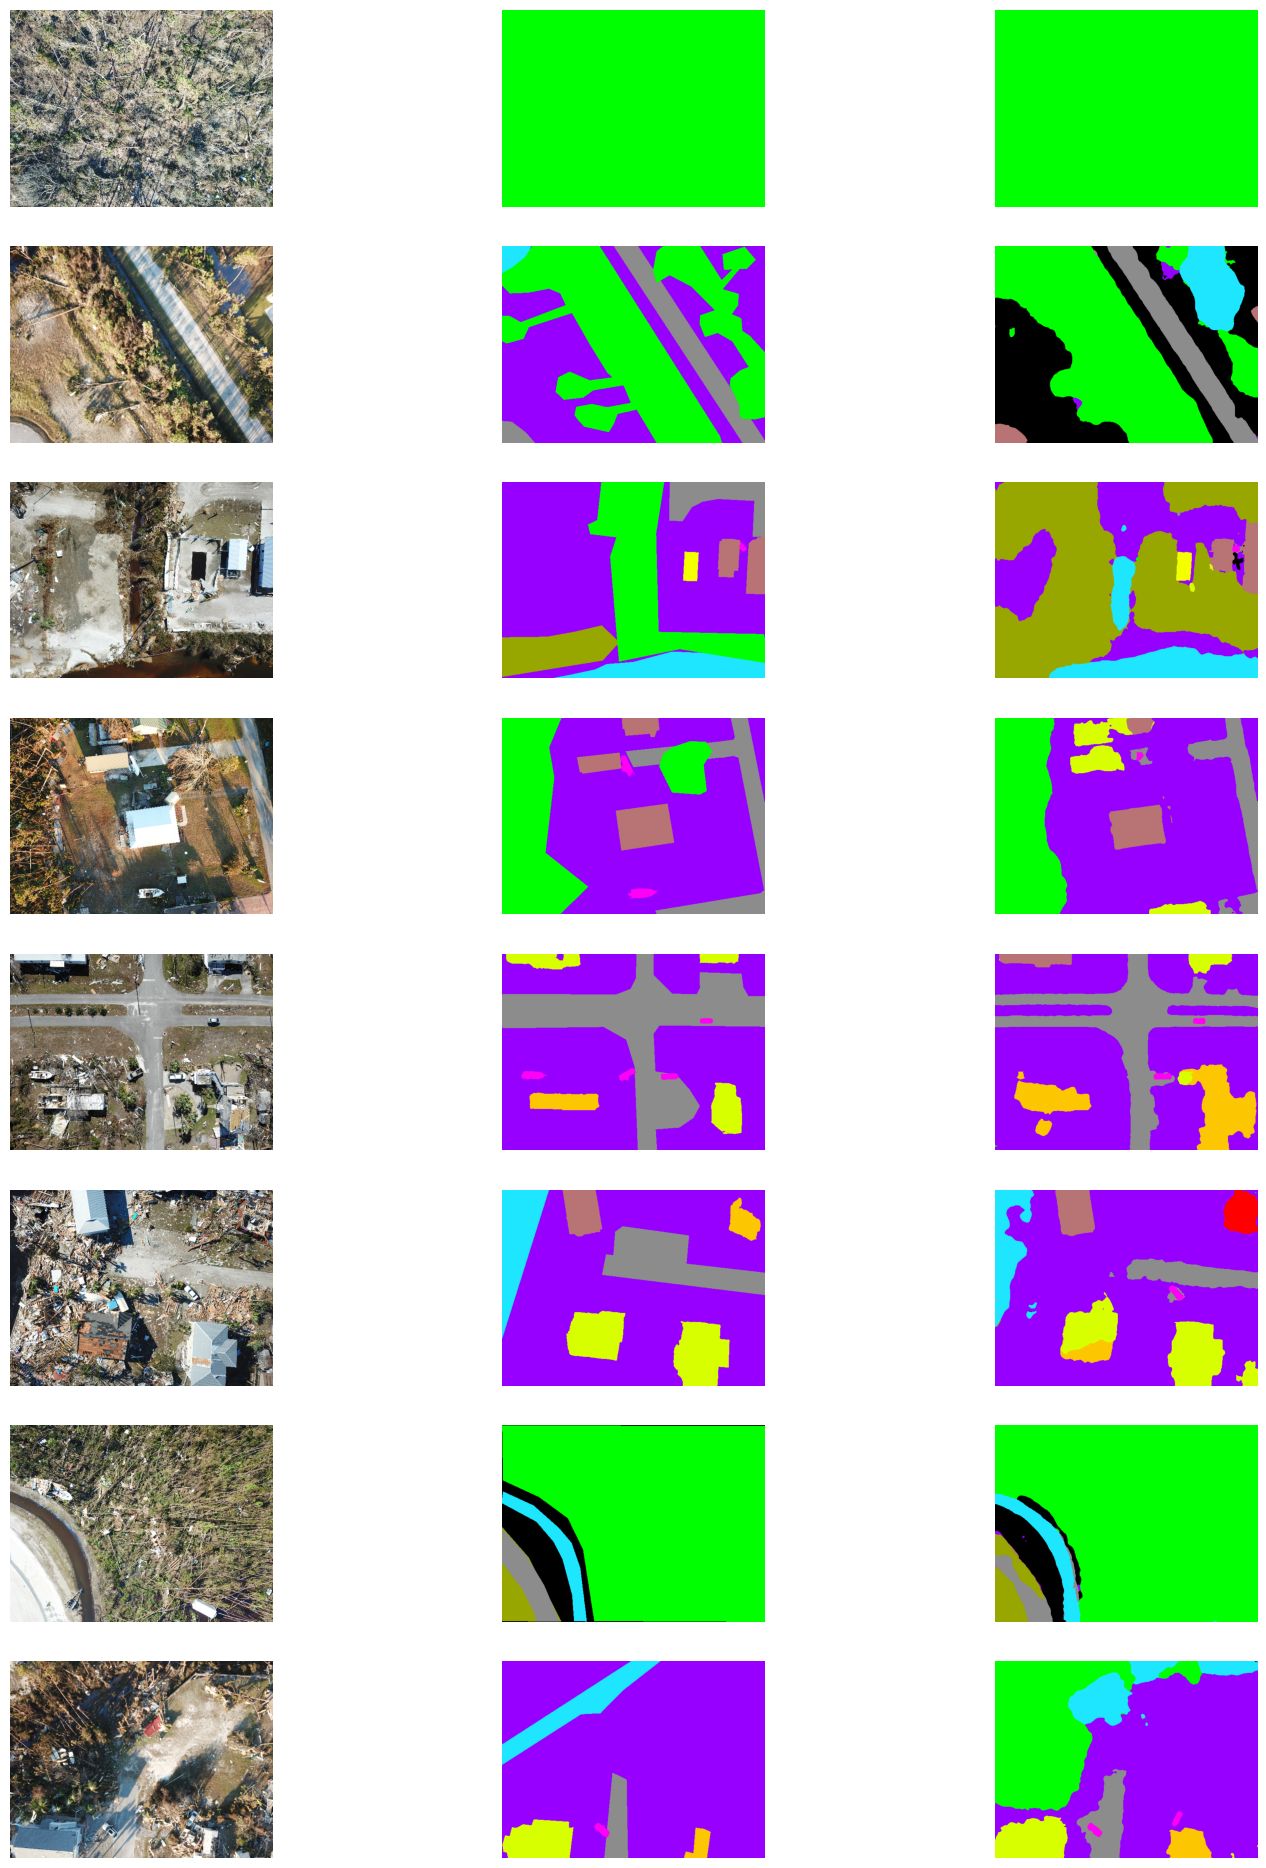

In [25]:
#display original image, groundtruth label, and prediction for each test sample in the batch. 
fig, axs = plt.subplots(nrows=TEST_BATCH_SIZE, ncols=3,figsize=(18,24))

for count in range(TEST_BATCH_SIZE):
    mask = np.argmax(masks[count].cpu().numpy(), axis=0)
    pred = np.argmax(preds[count].cpu().detach().numpy(), axis=0)
    pred_color = apply_color(pred)
    
    axs[count,0].imshow(imgs[count].permute(1,2,0))   
    axs[count,0].set_axis_off()
    axs[count,1].imshow(apply_color(mask))
    axs[count,1].set_axis_off()
    axs[count,2].imshow(pred_color)
    axs[count,2].set_axis_off()

In [ ]:
for i in range(20):
    # show predicted images
    imgs, masks = next(iterator)
    #predictions
    preds = model(imgs.to(DEVICE))
    #display original image, groundtruth label, and prediction for each test sample in the batch. 
    fig, axs = plt.subplots(nrows=TEST_BATCH_SIZE, ncols=3,figsize=(18,24))

    for count in range(TEST_BATCH_SIZE):
        mask = np.argmax(masks[count].cpu().numpy(), axis=0)
        pred = np.argmax(preds[count].cpu().detach().numpy(), axis=0)
        pred_color = apply_color(pred)

        axs[count,0].imshow(imgs[count].permute(1,2,0))   
        axs[count,0].set_axis_off()
        axs[count,1].imshow(apply_color(mask))
        axs[count,1].set_axis_off()
        axs[count,2].imshow(pred_color)
        axs[count,2].set_axis_off()

In [28]:
import segmentation_models_pytorch as smp
import torch
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch.utils


def test_one_epoch(model, test_loader, DEVICE=DEVICE):
    model.eval()
    with torch.no_grad():
        IoU_List = np.zeros(shape=12, dtype='float32')
        Fscore_List = np.zeros(shape=12, dtype='float32')
        
        iou_metric = smp.utils.metrics.IoU()  
        fscore_metric = smp.utils.metrics.Fscore()

        loop = tqdm(test_loader)
        
        for batch_index, (imgs, masks) in enumerate(loop):
            preds = model(imgs.to(DEVICE))  # shape [8,12,h,w]
            
            masks = masks.permute(1, 0, 2, 3)  # shape [12,8,h,w]
            preds_argmax = torch.argmax(preds, axis=1)  # shape [8,h,w]
            
            preds_stacked = (preds_argmax == 0).unsqueeze(0)  # shape [1,8,h,w]
            for i in range(1, 12):
                preds_stacked = torch.cat((preds_stacked, (preds_argmax == i).unsqueeze(0)))
                
            preds_stacked = preds_stacked.to(dtype=torch.int8)  # shape [12,8,h,w]

            for i in range(12):
                preds_layer = preds_stacked[i]  # shape [8,h,w]
                masks_layer = masks[i]  # shape [8,h,w]
                
                preds_layer = preds_layer.flatten()  # shape [8*h*w]
                masks_layer = masks_layer.flatten()  # shape [8*h*w]
                
                layer_iou = iou_metric(preds_layer.cpu(), masks_layer)  # one float number
                layer_fscore = fscore_metric(preds_layer.cpu(), masks_layer)  # one float number
                
                IoU_List[i] += layer_iou
                Fscore_List[i] += layer_fscore
                
            loop.set_postfix(
                background=IoU_List[0]/(batch_index+1),
                debris=IoU_List[1]/(batch_index+1),
                water=IoU_List[2]/(batch_index+1),
                building_no_damage=IoU_List[3]/(batch_index+1),
                building_minor_damage=IoU_List[4]/(batch_index+1),
                building_major_damage=IoU_List[5]/(batch_index+1),
                building_total_destruction=IoU_List[6]/(batch_index+1),
                vehicle=IoU_List[7]/(batch_index+1),
                road=IoU_List[8]/(batch_index+1),
                pool=IoU_List[9]/(batch_index+1),
                tree=IoU_List[10]/(batch_index+1),
                sand=IoU_List[11]/(batch_index+1),
                mean_IoU=IoU_List[1:12].mean()/(batch_index+1),
                mean_Fscore=Fscore_List[1:12].mean()/(batch_index+1)
            )

        IoU_List = IoU_List / len(test_loader)
        Fscore_List = Fscore_List / len(test_loader)

        print("background IoU = {}".format(IoU_List[0]))
        print("debris IoU = {}".format(IoU_List[1]))
        print("water IoU = {}".format(IoU_List[2]))
        print("building-no-damage IoU = {}".format(IoU_List[3]))
        print("building-minor-damage IoU = {}".format(IoU_List[4]))
        print("building-major-damage IoU = {}".format(IoU_List[5]))
        print("building-total-destruction IoU = {}".format(IoU_List[6]))
        print("vehicle IoU = {}".format(IoU_List[7]))
        print("road IoU = {}".format(IoU_List[8]))
        print("tree IoU = {}".format(IoU_List[9]))
        print("pool IoU = {}".format(IoU_List[10]))
        print("sand IoU = {}".format(IoU_List[11]))
        


        print("Test got mean IoU {}".format(IoU_List[1:12].mean()))
        print("Test got mean F1_score {}".format(Fscore_List[1:12].mean()))

In [29]:
test_one_epoch(model, test_loader)

100%|██████████| 56/56 [01:34<00:00,  1.69s/it, background=0.286, building_major_damage=0.353, building_minor_damage=0.419, building_no_damage=0.585, building_total_destruction=0.552, debris=0.572, mean_Fscore=0.711, mean_IoU=0.601, pool=0.75, road=0.674, sand=0.598, tree=0.819, vehicle=0.569, water=0.714] 

background IoU = 0.2863020598888397
debris IoU = 0.5718288421630859
water IoU = 0.7136675715446472
building-no-damage IoU = 0.5851595997810364
building-minor-damage IoU = 0.41937312483787537
building-major-damage IoU = 0.35321784019470215
building-total-destruction IoU = 0.5524985194206238
vehicle IoU = 0.569148600101471
road IoU = 0.6741120219230652
tree IoU = 0.7504692673683167
pool IoU = 0.8185386657714844
sand IoU = 0.5981339812278748
Test got mean IoU 0.600558876991272
Test got mean F1_score 0.7113689184188843


In [30]:
! pip install torchprofile 

In [33]:
from torchprofile import profile_macs
sample_data = torch.randn(1, 3,480, 640, ).cuda()

macs = profile_macs(model,sample_data)
print(f'The macs is {macs}')
print(f'The FLOPs is {macs*2}')

The macs is 14423128960
The FLOPs is 28846257920


/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::pad". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/opt/conda/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "prim::pythonop". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [34]:
import time

def measure_latency(model, input_data):
    start_time = time.time()
    # For GPU (PyTorch)
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    start_event.record()
    output = model(input_data)
    end_event.record()
    torch.cuda.synchronize()

    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time


measure_latency(model, sample_data)

0.024085044860839844

In [35]:
# Timing the model inference
start_time = time.time()
batch_sample_data = torch.randn(8, 3,480, 640, ).cuda()

# For GPU (PyTorch)
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()
output = model(batch_sample_data)
end_event.record()
torch.cuda.synchronize()

end_time = time.time()
inference_time = end_time - start_time

# Calculate FPS
batch_size = len(batch_sample_data)  # or whatever your batch size is
print(f"batch_size {batch_size}")
fps = batch_size / inference_time

print(f"Inference time: {inference_time:.4f} seconds")
print(f"FPS: {fps:.2f}")

batch_size 8
Inference time: 0.2689 seconds
FPS: 29.75


In [36]:
import time
import torch

def calculate_fps_latency(model, input_size, num_samples=100):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model (cuda or cpu)
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_samples):
            input_data = torch.rand(input_size).to(device)  # Move input data to the correct device
            output = model(input_data)
    end_time = time.time()
    
    total_time = end_time - start_time
    latency = (total_time / num_samples) * 1000  # in milliseconds
    fps = 1 / (total_time / num_samples)
    
    return fps, latency

input_size = (1, 3, 480, 640)
fps, latency = calculate_fps_latency(model, input_size)
print(f"FPS: {fps}")
print(f"Latency: {latency} ms")

FPS: 46.75654703067839
Latency: 21.38737916946411 ms
